In [115]:
import pandas as pd
## Utils and Library for notebook
from notebook_utils.OpenKbcMSToolkit import ExtractionToolkit as exttoolkit

# Root data path
DATA_PATH = '../data/'

#Data loading
df = pd.read_csv("resultFiles/featureExtractionV2_by_Jun/LongDiseaseDuration/CD4.Ranksum.RFECV.act.csv", engine='c', index_col=0)
meta_data = pd.read_csv(DATA_PATH+'annotation_metadata/EPIC_HCvB_metadata_baseline_updated-share.csv')


In [116]:
## Utils and Library for notebook
from notebook_utils.OpenKbcMSToolkit import ExtractionToolkit as exttoolkit
import itertools
def _LoadDiseaseDuration(df, meta_data, returntype='long'):
    """
    df : Expression or activation score matrix
    meta_data : meta data which contains duration and sample ID
    output: long DD samples and short DD samples by list, or healthy samples and short DD samples by list
    """
    # Sample by disease category
    sample_list, sample_category = exttoolkit.get_sample_name_by_category(dataframe=meta_data, sampleColumn='HCVB_ID', dataColname='DiseaseCourse')
    
    # Sort by disease category and exclude uknown samples
    patient_samples = [] # patient samples
    healthy_samples = [] # healthy samples
    for samples, category in zip(sample_list, sample_category):
        if category=='Healthy':
            healthy_samples = samples
        else:
            if category!='Unknown':# Excluding unknown samples
                patient_samples.append(samples)

    patient_samples = list(itertools.chain(*patient_samples)) # flatten
    patient_samples = list(set(patient_samples).intersection(df.columns.tolist())) # intersected with act score matrix
    healthy_samples = list(set(healthy_samples).intersection(df.columns.tolist())) # intersected with act score matrix
    patient_meta = meta_data.loc[meta_data['HCVB_ID'].isin(patient_samples)] # Make patient metadata

    longDD_samples, shortDD_samples = exttoolkit.get_sample_name_by_contValues(patient_meta, 'HCVB_ID', 'DiseaseDuration', 25)
    longDD_samples = list(set(longDD_samples.values.tolist()).intersection(df.columns.tolist())) # intersected with act score matrix
    shortDD_samples = list(set(shortDD_samples.values.tolist()).intersection(df.columns.tolist())) # intersected with act score matrix

    if returntype=='long':
        return longDD_samples, shortDD_samples
    elif returntype=='healthy':
        return healthy_samples, shortDD_samples

In [117]:
df_cd4 = df.copy()
longDD_samples, shortDD_samples = _LoadDiseaseDuration(df_cd4, meta_data, 'long')
df_cd4 = df_cd4[longDD_samples+shortDD_samples]
df_cd4 = df_cd4.subtract(df_cd4.median(axis=1), axis=0)


X = df_cd4.T.values # Training sample
y = [0]*len(longDD_samples)+[1]*len(shortDD_samples) # Training y
X.shape

(86, 402)

Optimal number of features : 259


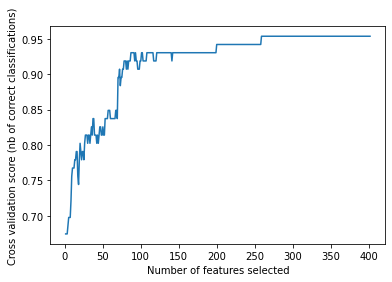

In [118]:
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV

## Reference: 
## https://scikit-learn.org/stable/auto_examples/feature_selection/plot_rfe_with_cross_validation.html

estimator = SVC(kernel="linear") # linear
min_features_to_select = 1
rfecv = RFECV(estimator=estimator, step=1, cv=StratifiedKFold(2),\
    scoring='accuracy', min_features_to_select=min_features_to_select)
rfecv.fit(X, y)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(min_features_to_select, len(rfecv.grid_scores_) + min_features_to_select), rfecv.grid_scores_)
plt.show()

In [119]:
rfecv.n_features_

259

In [120]:
import numpy as np
selected_features = df_cd4.index[np.where(rfecv.ranking_==1)] # Top100
selected_df = df_cd4.loc[selected_features]

fold_change = (selected_df[longDD_samples].mean(axis=1) - selected_df[shortDD_samples].mean(axis=1)).apply(abs)
fold_change = fold_change.sort_values(ascending=False)[:200].index.tolist()
selected_df = selected_df.loc[fold_change]

X = selected_df.T.values
y = [0]*len(longDD_samples)+[1]*len(shortDD_samples) # Training y
y = np.array(y)

In [121]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn import metrics

auc_arr = []
val_auc = []

for t in list(range(0,100)):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=t)
    X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=t)

    randomState = list(range(0,5))

    clf = SVC(kernel="linear")
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred, pos_label=1)
    auc_arr.append([t, metrics.auc(fpr, tpr)])
    
    y_val_pred = clf.predict(X_val)
    fpr, tpr, thresholds = metrics.roc_curve(y_val, y_val_pred, pos_label=1)
    val_auc.append([t, metrics.auc(fpr, tpr)])

auc_test_df = pd.DataFrame(data=auc_arr, columns=['state', 'auc']).set_index('state')
auc_val_df = pd.DataFrame(data=val_auc, columns=['state', 'auc']).set_index('state')

In [125]:
auc_df = pd.concat([auc_test_df, auc_val_df], axis=1)
auc_df.columns = ['test_auc', 'val_auc']
auc_df['diff'] = auc_df['test_auc'] - auc_df['val_auc']
auc_df

,test_auc,val_auc,diff
state,,,
0,1.000000,0.916667,0.083333
1,0.928571,0.900000,0.028571
2,1.000000,0.928571,0.071429
3,1.000000,1.000000,0.000000
4,0.900000,0.750000,0.150000
...,...,...,...
95,0.875000,1.000000,-0.125000
96,1.000000,0.750000,0.250000
97,1.000000,0.928571,0.071429


/opt/miniconda3/envs/r-py-test/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/miniconda3/envs/r-py-test/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

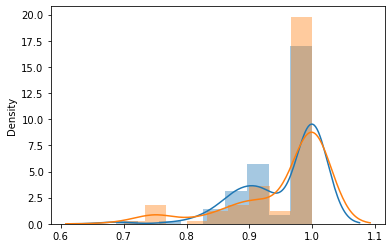

In [126]:
sns.distplot(auc_test_df['auc'].values.tolist())
sns.distplot(auc_val_df['auc'].values.tolist())

In [129]:
X_test.shape

(17, 200)

In [130]:
X_val.shape

(18, 200)

In [131]:
X_train.shape

(51, 200)